<a href="https://colab.research.google.com/github/byein/CAPTCHA_reader/blob/main/captcha_reader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

이미 완성까지 구현한 코드가 있어 정확도를 좀 더 높이고 효율적으로 동작할 수 있도록 코드 참조<br>
https://www.kaggle.com/ritabratanag/captcha-95-accuracy

#Initial Setting For Use Kaggle Data in the Colab

https://velog.io/@dunhill741/%EA%B5%AC%EA%B8%80-colab%EC%97%90%EC%84%9C-kaggle-%EB%8D%B0%EC%9D%B4%ED%84%B0-%EC%9D%B4%EC%9A%A9%ED%95%98%EB%8A%94-%EB%B2%95



In [1]:
!pip install kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yebkim","key":"9087c0a2cfce87113d835781c46f5915"}'}

In [3]:
!ls -al
!mkdir -p ~/.kaggle
!ls -al ~/

total 20
drwxr-xr-x 1 root root 4096 Dec 20 10:23 .
drwxr-xr-x 1 root root 4096 Dec 20 10:21 ..
drwxr-xr-x 4 root root 4096 Dec  3 14:33 .config
-rw-r--r-- 1 root root   62 Dec 20 10:23 kaggle.json
drwxr-xr-x 1 root root 4096 Dec  3 14:33 sample_data
total 64
drwx------ 1 root root 4096 Dec 20 10:23 .
drwxr-xr-x 1 root root 4096 Dec 20 10:21 ..
-r-xr-xr-x 1 root root 1169 Jan  1  2000 .bashrc
drwxr-xr-x 1 root root 4096 Dec 14 14:13 .cache
drwxr-xr-x 1 root root 4096 Dec 14 14:11 .config
drwxr-xr-x 3 root root 4096 Dec  3 14:33 .gsutil
drwxr-xr-x 5 root root 4096 Dec 14 14:11 .ipython
drwx------ 2 root root 4096 Dec 14 14:11 .jupyter
drwxr-xr-x 2 root root 4096 Dec 20 10:23 .kaggle
drwxr-xr-x 2 root root 4096 Dec 20 10:21 .keras
drwx------ 1 root root 4096 Dec 14 14:11 .local
drwxr-xr-x 4 root root 4096 Dec 14 14:11 .npm
-rw-r--r-- 1 root root  148 Aug 17  2015 .profile
-r-xr-xr-x 1 root root  254 Jan  1  2000 .tmux.conf


In [4]:
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!ls -al ~/.kaggle/

total 16
drwxr-xr-x 2 root root 4096 Dec 20 10:23 .
drwx------ 1 root root 4096 Dec 20 10:23 ..
-rw------- 1 root root   62 Dec 20 10:23 kaggle.json


In [5]:
!kaggle datasets download -d fournierp/captcha-version-2-images

 52% 9.00M/17.4M [00:00<00:00, 13.0MB/s]
100% 17.4M/17.4M [00:00<00:00, 21.1MB/s]


In [6]:
!unzip captcha-version-2-images.zip

Archive:  captcha-version-2-images.zip
  inflating: samples/226md.png       
  inflating: samples/22d5n.png       
  inflating: samples/2356g.png       
  inflating: samples/23mdg.png       
  inflating: samples/23n88.png       
  inflating: samples/243mm.png       
  inflating: samples/244e2.png       
  inflating: samples/245y5.png       
  inflating: samples/24f6w.png       
  inflating: samples/24pew.png       
  inflating: samples/25257.png       
  inflating: samples/253dc.png       
  inflating: samples/25egp.png       
  inflating: samples/25m6p.png       
  inflating: samples/25p2m.png       
  inflating: samples/25w53.png       
  inflating: samples/264m5.png       
  inflating: samples/268g2.png       
  inflating: samples/28348.png       
  inflating: samples/28x47.png       
  inflating: samples/2b827.png       
  inflating: samples/2bg48.png       
  inflating: samples/2cegf.png       
  inflating: samples/2cg58.png       
  inflating: samples/2cgyx.png       
  inflating

#Import Required libraries

In [7]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import os
import numpy as np
import pandas as pd
from tensorflow import keras as k
from keras.utils import np_utils
import cv2
from PIL import Image
from keras.preprocessing.image import img_to_array, ImageDataGenerator
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Activation, MaxPooling2D, Flatten, Conv2D, Dropout, Dense

#Loading Dataset and Preprocessing

###ADAPTIVE THRESHOLD
Adaptive Threshold - 모든 픽셀에 같은 threshold 값 적용.<BR>
픽셀의 값이 threshold 값보다 작으면 0, 크면 최대값으로 설정. -> THRESH_BINARY<BR>
이미지에서 회색빛 제거.                          
<BR>
덜 선명하더라도 잡티가 하나도 없기를 원하기 때문에 MEAN이 아닌 ADAPTIVE_THRESH_GAUSSIAN_C 사용.
<BR>
* 첫번째 아규먼트는 원본 이미지
* 두번째 아규먼트는 임계값 이상일 경우 픽셀값
* 세번째 아규먼트는 적응형 이진화 타입
* 네번째 아규먼트는 이진화 타입
* 다섯째 아규먼트는 임계값 계산시 함께 볼 주변 픽셀의 범위를 블럭 크기로 지정
* 여섯번째 아규먼트는 평균 또는 가중평균에서 뺄 값 

###Open-CV
https://hoony-gunputer.tistory.com/entry/opencv-pythonErosion%EA%B3%BC-Dilation

https://diyver.tistory.com/61

https://diyver.tistory.com/67

https://dmcworks-2019-deep-learning.tistory.com/18




In [8]:
x=[]
y=[]

# 데이터가 samples 안에 samples 폴더가 중첩되어 있기 때문에 nested for 문 사용.
for dirname, _, filenames in os.walk('samples'):
    for filename in filenames:
        path=os.path.join(dirname, filename) 
        
# 이미지 전처리 과정
#     이미지를 Grayscale로 읽어들여 캡차 이미지에서 색이라는 변수 제거.
        image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

#     Adaptive Threshold - 모든 픽셀에 같은 threshold 값 적용.
#                          픽셀의 값이 threshold 값보다 작으면 0, 크면 최대값으로 설정. -> THRESH_BINARY
#                          -> 이미지에서 회색빛 제거.
        image = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 145, 0)
  
# - Closing: 전반적인 이미지 개선. 실질적 정확도의 증가. 이 작업을 거치지 않으면 e나 c 와 같은 비슷한 경우 제대로 판별 불가. 
        kernel = np.ones((5,5),np.uint8)
        image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)

# - Opening 사용시 정확도 떨어져 예상결과가 다르게 나와 사용하지 않기로 결정.       
        # kernel = np.ones((5,5),np.uint8)
        # image = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

# - Dilation: 이미지 팽창으로 정확도 높임. 실질적 정확도의 증가. closing과 같이 이 작업을 제대로 거치지 않으면 정확도 떨어짐.
        kernel = np.ones((2,2),np.uint8)
        image = cv2.dilate(image, kernel, iterations = 1)
 
# - Blur: 가우시안 블러를 사용하여 중앙값에 가중치를 두어 주변을 흐리게 하여 숫자 외 노이즈 제거. 이 코드가 없으면 Blur 처리로 이미 변형이 일어난 경우 판별이 어려움.
        image = cv2.GaussianBlur(image, (5,5), 0)
 

# 이미지 사이즈가 동일하게 문자를 하나씩 자르기. 총 5개의 문자로 이뤄져 있기 때문에 5개로 나누어 데이터의 사이즈를 모두 동일하게 처리. 20 * 20의 정사각형 형태로 자름.
        x_split=[image[10:50,30:50],image[10:50,50:70],
                 image[10:50,70:90],image[10:50,90:110],image[10:50,110:130]]

# x에는 이미지 배열을, y에는 라벨을 저장.
        for i in range(5):
            x.append(img_to_array(Image.fromarray(x_split[i])))
            y.append(path[len(path)-9:len(path)-4][i])
x=np.array(x)
y=np.array(y)


#Scaling X values; Label Encoding and One Hot Encoding the labels

LabelEncoder - 라벨을 숫자로 반환.
OneHotEncoder - 숫자간 가중치 동일하게 처리.

https://mizykk.tistory.com/10

https://3months.tistory.com/207

https://steadiness-193.tistory.com/244

https://hwi-doc.tistory.com/entry/%EB%B2%94%EC%A3%BC%ED%98%95-%EB%B3%80%EC%88%98-%EC%B2%98%EB%A6%AC-%EB%B0%A9%EB%B2%95

https://deepinsight.tistory.com/165

https://khalidpark2029.tistory.com/82


test/validation 분리

https://teddylee777.github.io/scikit-learn/train-test-split

In [9]:
x=x.astype('float32')
x/=255

# 0 ~ z 까지 라벨링 되어있는 것들을 숫자로 반환하고 가중치를 동일하게 처리하여 데이터 처리
y_le = LabelEncoder().fit_transform(y)
y_ohe = OneHotEncoder(sparse = False).fit_transform(y_le.reshape(len(y_le),1))

# train과 test 셋으로 나눔. 랜덤으로 나눔.
x_train, x_test, y_train, y_test = train_test_split(x, y_ohe, test_size = 0.25, random_state = 42)

row, col = x.shape[1],x.shape[2]
categories = y_ohe.shape[1]

info = {y_le[i] : y[i] for i in range(len(y))}


#Creating the CNN architecture

https://buomsoo-kim.github.io/keras/2018/05/02/Easy-deep-learning-with-Keras-8.md/

https://cheris8.github.io/artificial%20intelligence/DL-Keras-Loss-Function/


관련하여 공부하고 정리한 본인 블로그 : https://byein.tistory.com/category/ICT%20%EB%A9%98%ED%86%A0%EB%A7%81/%ED%98%BC%EC%9E%90%20%EA%B3%B5%EB%B6%80%ED%95%98%EB%8A%94%20%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D%2B%EB%94%A5%EB%9F%AC%EB%8B%9D






In [10]:
model = Sequential()

model.add(Conv2D(filters=16,kernel_size=(3,3), padding='same', input_shape=(row,col,1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

# 더 세부적으로 나눌 수 있지만 충분히 정확하게 동작하여 간단하게 나누기로 결정.

model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(1500))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(categories))
model.add(Activation("softmax"))

model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam' ,
              metrics = ['accuracy'])

print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 40, 20, 16)        160       
                                                                 
 activation (Activation)     (None, 40, 20, 16)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 20, 10, 16)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 3200)              0         
                                                                 
 dropout (Dropout)           (None, 3200)              0         
                                                                 
 dense (Dense)               (None, 1500)              4801500   
                                                        

#Fitting and training data into model

https://sevillabk.github.io/1-batch-epoch/

관련하여 공부하고 정리한 본인 블로그 : https://byein.tistory.com/category/ICT%20%EB%A9%98%ED%86%A0%EB%A7%81/%ED%98%BC%EC%9E%90%20%EA%B3%B5%EB%B6%80%ED%95%98%EB%8A%94%20%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D%2B%EB%94%A5%EB%9F%AC%EB%8B%9D

In [11]:
# batch size가 너무 작으면 학습 시간은 오래 걸리면서 정확도가 오히려 떨어졌음. 효율적인 학습을 위해 64 정도로 batch size 설정.
# epoch가 200일 때나 100일 때 큰 차이가 없음. 더 효율적인 것은 학습 시간이 더 적은 100으로 판단.
batch_size = 64
epochs = 100

history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test),
          shuffle=True)

Epoch 1/100
126/126 [==============================] - 14s 13ms/step - loss: 1.8484 - accuracy: 0.4952 - val_loss: 1.0496 - val_accuracy: 0.7181
Epoch 2/100
126/126 [==============================] - 1s 10ms/step - loss: 0.9770 - accuracy: 0.7338 - val_loss: 0.8071 - val_accuracy: 0.7929
Epoch 3/100
126/126 [==============================] - 1s 12ms/step - loss: 0.7695 - accuracy: 0.7941 - val_loss: 0.6342 - val_accuracy: 0.8236
Epoch 4/100
126/126 [==============================] - 1s 10ms/step - loss: 0.6246 - accuracy: 0.8334 - val_loss: 0.5445 - val_accuracy: 0.8490
Epoch 5/100
126/126 [==============================] - 1s 12ms/step - loss: 0.5239 - accuracy: 0.8592 - val_loss: 0.4652 - val_accuracy: 0.8692
Epoch 6/100
126/126 [==============================] - 1s 11ms/step - loss: 0.4504 - accuracy: 0.8735 - val_loss: 0.4074 - val_accuracy: 0.8826
Epoch 7/100
126/126 [==============================] - 1s 11ms/step - loss: 0.3930 - accuracy: 0.8902 - val_loss: 0.3785 - val_accuracy

#Evaluating performance of the model


In [12]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

84/84 [==============================] - 0s 5ms/step - loss: 0.1672 - accuracy: 0.9746
Test loss: 0.1671600341796875
Test accuracy: 0.9745794534683228


#Prediction Function:
데이터의 가공이 필요. 가공방식은 위에서 처리한 것과 동일하게 처리

In [13]:
def pred (img_path) :
    
    # grayscale
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()
    
    # 위와 동일. adaptiveThreshold -> closing -> dilate -> GaussionBlur 사용
    image = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 145, 0)
    kernel = np.ones((5,5),np.uint8)
    image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    kernel = np.ones((2,2),np.uint8)
    image = cv2.dilate(image, kernel, iterations = 1)
    image = cv2.GaussianBlur(image, (5,5), 0)
    
    # 데이터 사이즈 자르기
    x = [image[10:50, 30:50], image[10:50, 50:70], image[10:50, 70:90],
                  image[10:50, 90:110], image[10:50, 110:130]]
    
    X_pred = []
    for i in range(5) :
        X_pred.append(img_to_array(Image.fromarray(x[i])))
    
    X_pred = np.array(X_pred)
    X_pred/= 255.0
    
    y_pred = model.predict(X_pred)
    y_pred = np.argmax(y_pred, axis = 1)
    
    print('Prediction: ', end='')
    for res in y_pred :
        print(info[res], end='')
        
    print('\nActual: ', img_path[len(img_path)-9:len(img_path)-4])

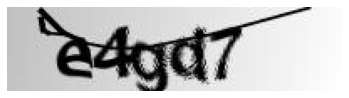

Prediction: e4gd7
Actual:  e4gd7


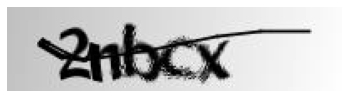

Prediction: 2nbcx
Actual:  2nbcx


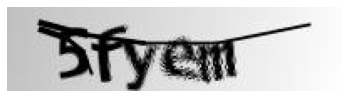

Prediction: 5fyem
Actual:  5fyem


In [14]:
pred('samples/samples/e4gd7.png')

pred('samples/samples/2nbcx.png')

pred('samples/samples/5fyem.png')


In [15]:
model.save('captcha_recognizer_v1.h5')
